# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band3.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3        4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.964952 -0.316784 -0.85217 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.964952 -0.316784 -0.85217 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.964952 -0.316784 -0.85217 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.964952 -0.316784 -0.85217 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.964952 -0.316784 -0.85217 -1.0 -1.0 -1.0 -1.0   

                    9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.89722  ...  -1.0 -0.822666 -0.886071  -1.0  -1.0 -0.578939   
      201547 -0.89722  ...  -1.0 -0.822666 -0.886071  -1.0  -1.0 -0.578939   
      201548 -0.89722  ...  -1.0 -0.822666 -0.886071  -1.0  -1.0 -0.578939   
      201549 -0.89722  ...  -1.0 -0.822666 -0.886071  -1.0  -1.0 -0.578939   
      201550 -0.89722  ...  -1.0 -0.822666 -0.886071  -1.0  -1.0 -0.578939   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.914666  -1.0 -0.861740  
      201547  -1.0 -0.914666  -1.0 -0.854589  
      201548  -1.0 -0.914666  -1.0 -0.856973  
      201549  -1.0 -0.914666  -1.0 -0.856973  
      201550  -1.0 -0.914666  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0    1         2         3        4    5         6         7  \
5360 201546 -1.0 -1.0 -0.964952 -0.316784 -0.85217 -1.0 -1.000000 -1.000000   
     201547 -1.0 -1.0 -0.461538 -1.000000 -1.00000 -1.0 -1.000000 -1.000000   
     201548 -1.0 -1.0 -0.964952 -0.316784 -0.85217 -1.0 -1.000000 -1.000000   
     201549 -1.0 -1.0 -0.512765 -1.000000 -1.00000 -1.0 -0.922008 -0.993894   
     201550 -1.0 -1.0 -0.964952 -0.316784 -0.85217 -1.0 -1.000000 -1.000000   

                    8         9  ...  2039      2040      2041  2042  \
5360 201546 -1.000000 -0.897220  ...  -1.0 -0.822666 -0.886071  -1.0   
     201547 -0.995048 -1.000000  ...  -1.0 -0.647474 -1.000000  -1.0   
     201548 -1.000000 -0.897220  ...  -1.0 -0.822666 -0.886071  -1.0   
     201549 -1.000000 -0.757954  ...  -1.0 -0.809043 -1.000000  -1.0   
     201550 -1.000000 -0.897220  ...  -1.0 -0.822666 -0.886071  -1.0   

                 2043      2044  2045      2046  2047    Labels  
5360 201546 -1.000000 -0.578939  -1.0 -0.914666  -1.0 -0.990465  
     201547 -0.870164 -1.000000  -1.0 -0.841541  -1.0 -0.969011  
     201548 -1.000000 -0.578939  -1.0 -0.914666  -1.0 -0.995232  
     201549 -0.996228 -0.985291  -1.0 -0.909708  -1.0 -0.997616  
     201550 -1.000000 -0.578939  -1.0 -0.914666  -1.0 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 2048)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 2048)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

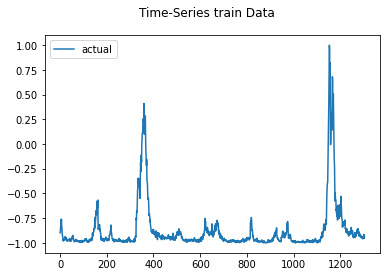

2023-03-06 14:08:10.384062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 14:08:10.384101: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 14:08:10.384126: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 14:08:10.384388: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 14:08:10.698958: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 62.230
Test RMSE: 76.562
Test sMAPE: 151.470
Test R Squared: -4.395
{'mae': 62.22966902616199, 'rmse': 76.56155356297516, 'smape': 151.47030170114854, 'r2': -4.39520425429047}


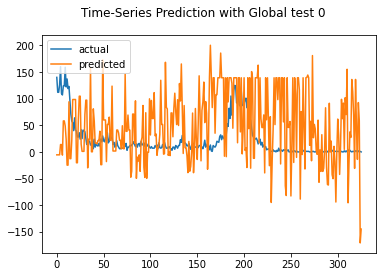

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 53.652
Test RMSE: 60.853
Test sMAPE: 132.855
Test R Squared: -2.408
{'mae': 53.652158438428046, 'rmse': 60.85331831361902, 'smape': 132.85516047362592, 'r2': -2.4084344527182293}


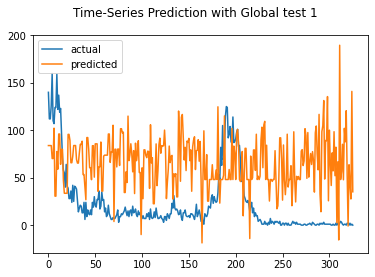

Test MAE: 51.568
Test RMSE: 81.916
Test sMAPE: 135.132
Test R Squared: -5.176
{'mae': 51.56822089759484, 'rmse': 81.91635100754088, 'smape': 135.1316958655574, 'r2': -5.176289049683799}


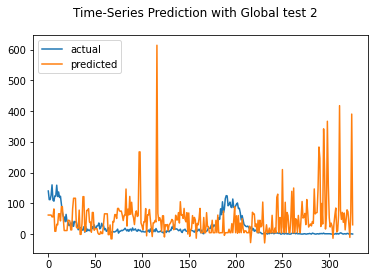

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 49.428
Test RMSE: 56.102
Test sMAPE: 131.885
Test R Squared: -1.897
{'mae': 49.42818157000045, 'rmse': 56.10188969429746, 'smape': 131.88531321352437, 'r2': -1.8969526453334242}


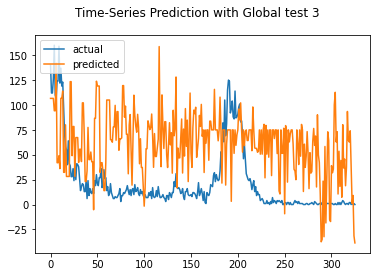

Test MAE: 90.939
Test RMSE: 102.095
Test sMAPE: 154.621
Test R Squared: -8.594
{'mae': 90.9386715567185, 'rmse': 102.09523122517537, 'smape': 154.62127944827978, 'r2': -8.593947339813901}


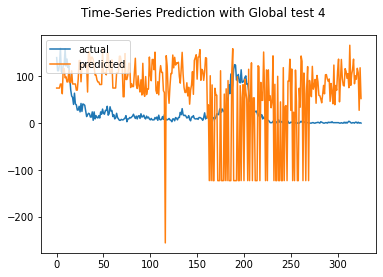

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 60.842
Test RMSE: 78.449
Test sMAPE: 149.510
Test R Squared: -4.664
{'mae': 60.841771686369654, 'rmse': 78.44875856408021, 'smape': 149.51020298405936, 'r2': -4.664460685799348}


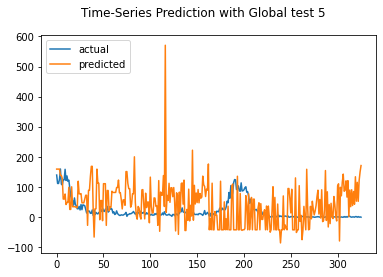

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 54.906
Test RMSE: 66.012
Test sMAPE: 136.843
Test R Squared: -3.011
{'mae': 54.90624698685722, 'rmse': 66.01224430013981, 'smape': 136.84288732698047, 'r2': -3.010840694646469}


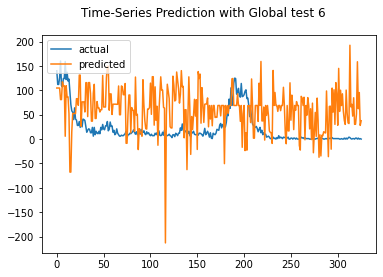

Test MAE: 68.062
Test RMSE: 87.060
Test sMAPE: 148.978
Test R Squared: -5.976
{'mae': 68.06202857607713, 'rmse': 87.06037478899151, 'smape': 148.9780667950485, 'r2': -5.976337474738535}


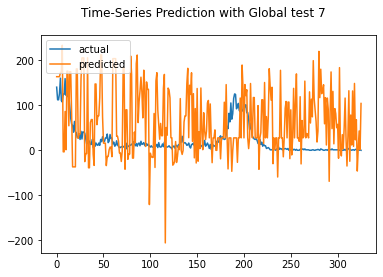

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 44.784
Test RMSE: 56.115
Test sMAPE: 137.807
Test R Squared: -1.898
{'mae': 44.78353591327287, 'rmse': 56.114988293179714, 'smape': 137.8069613492643, 'r2': -1.8983055569976681}


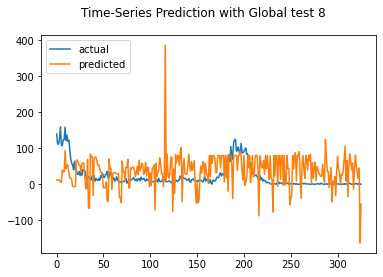

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 57.437
Test RMSE: 71.169
Test sMAPE: 141.029
Test R Squared: -3.662
{'mae': 57.436960762446645, 'rmse': 71.16920826354088, 'smape': 141.02920488150255, 'r2': -3.6619829956999723}


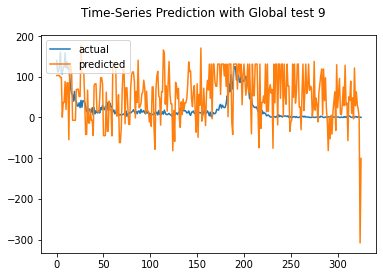

Test MAE: 143.870
Test RMSE: 166.959
Test sMAPE: 175.919
Test R Squared: -24.657
{'mae': 143.86975506441726, 'rmse': 166.95899159610067, 'smape': 175.91874455470966, 'r2': -24.657009926471247}


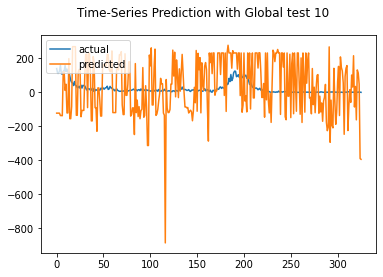

Test MAE: 56.863
Test RMSE: 72.120
Test sMAPE: 130.203
Test R Squared: -3.787
{'mae': 56.862818394701904, 'rmse': 72.11956739470344, 'smape': 130.20258750776406, 'r2': -3.78732202873055}


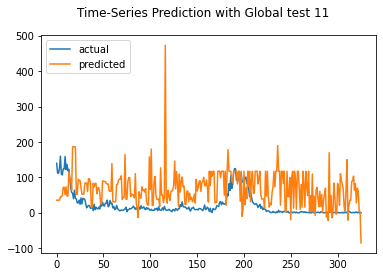

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 57.798
Test RMSE: 72.432
Test sMAPE: 147.073
Test R Squared: -3.829
{'mae': 57.79837120383795, 'rmse': 72.4321446281006, 'smape': 147.07339832225003, 'r2': -3.8289099294785673}


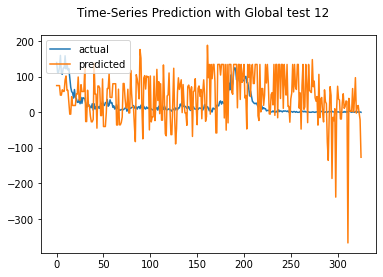

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 63.294
Test RMSE: 77.288
Test sMAPE: 136.804
Test R Squared: -4.498
{'mae': 63.29365114639142, 'rmse': 77.2882362302097, 'smape': 136.80396407198862, 'r2': -4.498107275320847}


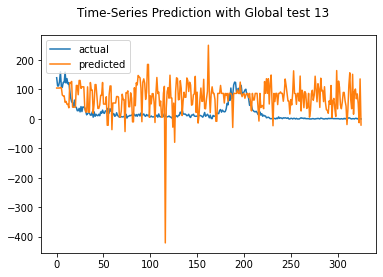

Test MAE: 71.845
Test RMSE: 95.939
Test sMAPE: 150.851
Test R Squared: -7.472
{'mae': 71.84533996029866, 'rmse': 95.93891820111553, 'smape': 150.85092664267628, 'r2': -7.471806942223271}


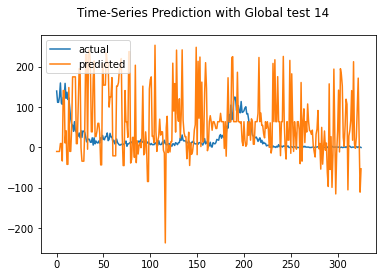

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 67.137
Test RMSE: 92.923
Test sMAPE: 145.971
Test R Squared: -6.948
{'mae': 67.13718757654992, 'rmse': 92.92281727800561, 'smape': 145.9706480591395, 'r2': -6.9475112831822825}


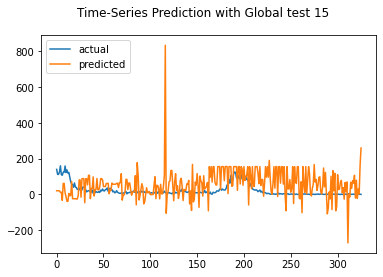

Test MAE: 46.476
Test RMSE: 66.507
Test sMAPE: 140.356
Test R Squared: -3.071
{'mae': 46.47593359676607, 'rmse': 66.50726891417087, 'smape': 140.355807110559, 'r2': -3.0712206853684343}


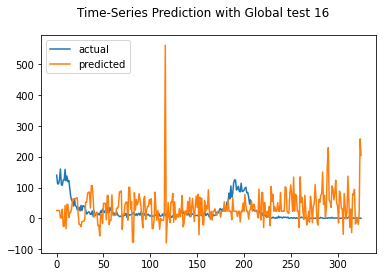

Test MAE: 90.154
Test RMSE: 142.942
Test sMAPE: 151.219
Test R Squared: -17.806
{'mae': 90.15427650008465, 'rmse': 142.94164732562766, 'smape': 151.21902747597997, 'r2': -17.806326938219097}


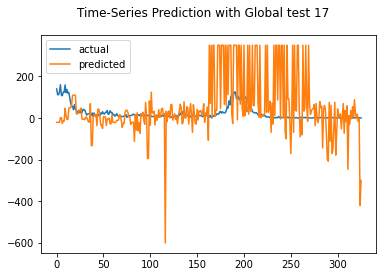

Test MAE: 69.962
Test RMSE: 83.224
Test sMAPE: 138.802
Test R Squared: -5.375
{'mae': 69.96194630312773, 'rmse': 83.22401062403095, 'smape': 138.80195338889533, 'r2': -5.375051507973815}


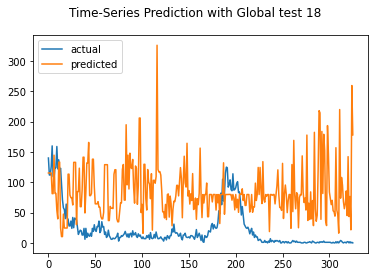

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 49.289
Test RMSE: 64.456
Test sMAPE: 162.406
Test R Squared: -2.824
{'mae': 49.28913205752343, 'rmse': 64.45591025374296, 'smape': 162.4058524690665, 'r2': -2.8239473854660258}


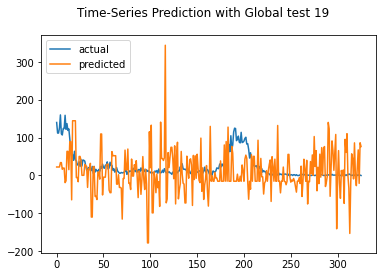

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 61.529
Test RMSE: 78.450
Test sMAPE: 137.471
Test R Squared: -4.665
{'mae': 61.52875026987374, 'rmse': 78.450090303227, 'smape': 137.47090530458658, 'r2': -4.664653006193156}


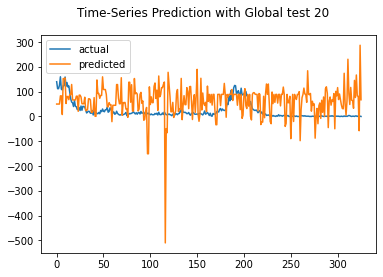

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 53.051
Test RMSE: 66.580
Test sMAPE: 148.748
Test R Squared: -3.080
{'mae': 53.05080945533843, 'rmse': 66.58008314609056, 'smape': 148.74781770316372, 'r2': -3.0801401640791948}


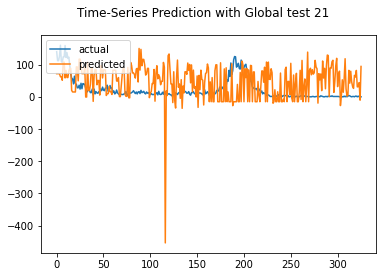

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 50.509
Test RMSE: 90.877
Test sMAPE: 139.214
Test R Squared: -6.601
{'mae': 50.50873846601855, 'rmse': 90.87721251849364, 'smape': 139.2137589750841, 'r2': -6.6014494379393325}


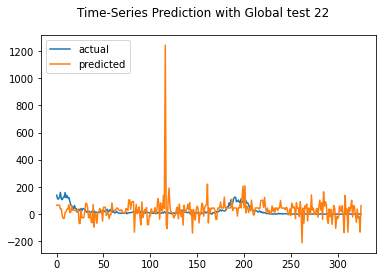

Test MAE: 57.250
Test RMSE: 64.598
Test sMAPE: 136.360
Test R Squared: -2.841
{'mae': 57.25038150720801, 'rmse': 64.59812131934045, 'smape': 136.36033985799432, 'r2': -2.8408397864924204}


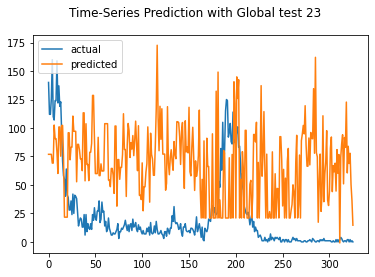

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 61.069
Test RMSE: 82.355
Test sMAPE: 143.058
Test R Squared: -5.243
{'mae': 61.069443495544185, 'rmse': 82.35495052608483, 'smape': 143.0581688460075, 'r2': -5.24260473543943}


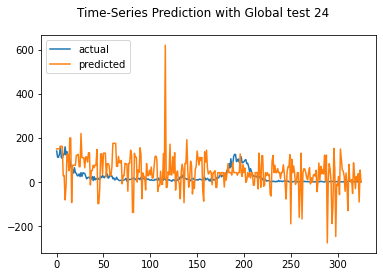

Test MAE: 67.783
Test RMSE: 87.333
Test sMAPE: 139.703
Test R Squared: -6.020
{'mae': 67.78303040298948, 'rmse': 87.33345902418297, 'smape': 139.70347538806595, 'r2': -6.020171784364002}


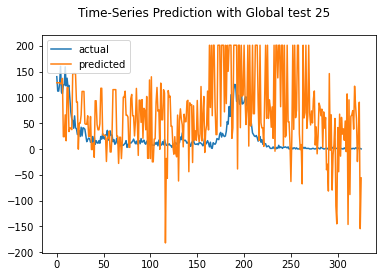

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 63.938
Test RMSE: 87.900
Test sMAPE: 143.877
Test R Squared: -6.111
{'mae': 63.93844774612254, 'rmse': 87.89959528764159, 'smape': 143.87680640506434, 'r2': -6.111482852101486}


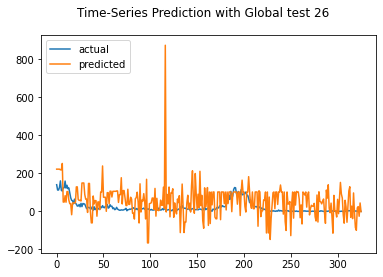

Test MAE: 56.722
Test RMSE: 65.515
Test sMAPE: 132.026
Test R Squared: -2.951
{'mae': 56.722057794500714, 'rmse': 65.51488399893685, 'smape': 132.02568682632867, 'r2': -2.95063010620364}


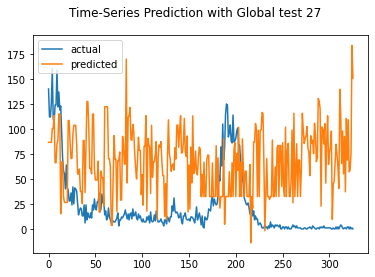

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 66.895
Test RMSE: 90.972
Test sMAPE: 141.973
Test R Squared: -6.617
{'mae': 66.89529465056636, 'rmse': 90.97189119712566, 'smape': 141.97253349218155, 'r2': -6.617296536872545}


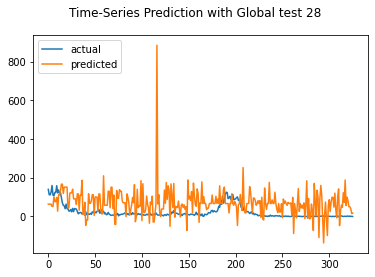

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 46.880
Test RMSE: 56.528
Test sMAPE: 131.511
Test R Squared: -1.941
{'mae': 46.879889002606916, 'rmse': 56.528091556466016, 'smape': 131.51089310713138, 'r2': -1.941135703328643}


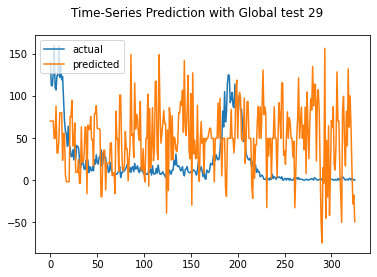

Test MAE: 50.137
Test RMSE: 70.415
Test sMAPE: 139.910
Test R Squared: -3.564
{'mae': 50.136913511833534, 'rmse': 70.41455145521664, 'smape': 139.90951146060863, 'r2': -3.5636386599229395}


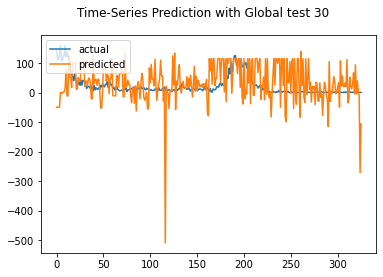

Test MAE: 46.046
Test RMSE: 73.283
Test sMAPE: 132.942
Test R Squared: -3.943
{'mae': 46.045810611884285, 'rmse': 73.28311547521604, 'smape': 132.9420282745548, 'r2': -3.9430415895390807}


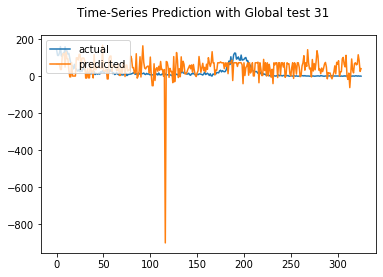

Test MAE: 83.274
Test RMSE: 95.345
Test sMAPE: 143.156
Test R Squared: -7.367
{'mae': 83.27411382339118, 'rmse': 95.34451631802303, 'smape': 143.15579685181913, 'r2': -7.367155804582632}


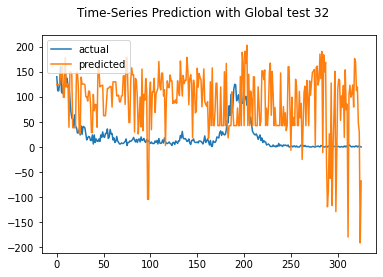

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 53.512
Test RMSE: 72.334
Test sMAPE: 136.637
Test R Squared: -3.816
{'mae': 53.51160485027758, 'rmse': 72.33353238487838, 'smape': 136.63650186824844, 'r2': -3.8157703078269343}


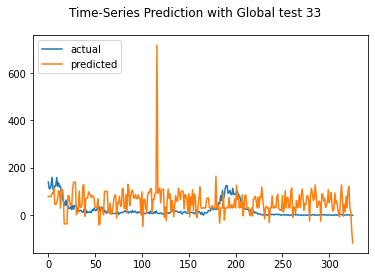

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 63.636
Test RMSE: 93.198
Test sMAPE: 163.736
Test R Squared: -6.995
{'mae': 63.636444184037806, 'rmse': 93.19823651202417, 'smape': 163.73578094648133, 'r2': -6.9946932656740595}


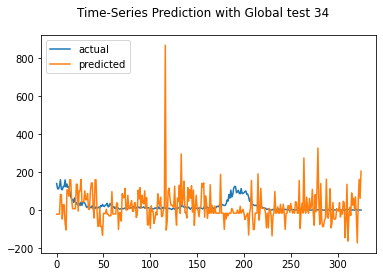

Test MAE: 36.884
Test RMSE: 50.387
Test sMAPE: 130.569
Test R Squared: -1.337
{'mae': 36.88423588241171, 'rmse': 50.38657255986325, 'smape': 130.5687845425842, 'r2': -1.3367704443205288}


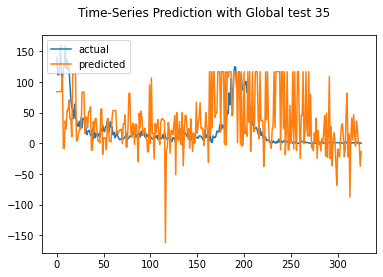

Test MAE: 86.226
Test RMSE: 100.897
Test sMAPE: 145.275
Test R Squared: -8.370
{'mae': 86.2263213061482, 'rmse': 100.89702023394219, 'smape': 145.27459070635646, 'r2': -8.370075650821454}


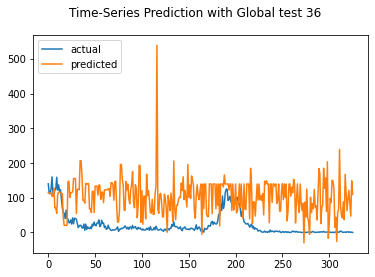

Test MAE: 53.328
Test RMSE: 77.588
Test sMAPE: 166.032
Test R Squared: -4.541
{'mae': 53.32841818775136, 'rmse': 77.58839575138502, 'smape': 166.03227715593343, 'r2': -4.540895516572747}


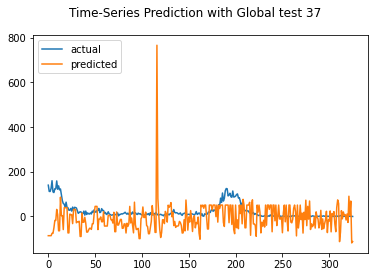

Test MAE: 64.176
Test RMSE: 73.745
Test sMAPE: 137.885
Test R Squared: -4.006
{'mae': 64.17600982960748, 'rmse': 73.74544572895695, 'smape': 137.88503042037252, 'r2': -4.005607884396851}


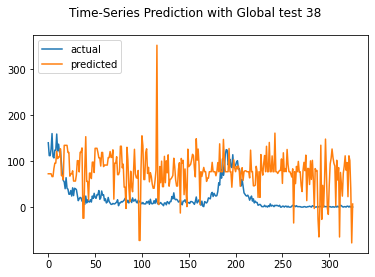

Test MAE: 65.998
Test RMSE: 74.268
Test sMAPE: 149.374
Test R Squared: -4.077
{'mae': 65.99793190312532, 'rmse': 74.26824521810859, 'smape': 149.37352136583092, 'r2': -4.076831408627031}


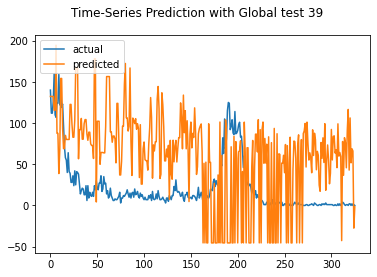

Test MAE: 76.021
Test RMSE: 87.471
Test sMAPE: 140.647
Test R Squared: -6.042
{'mae': 76.02072460775726, 'rmse': 87.47060579216576, 'smape': 140.64736776254085, 'r2': -6.042237779644025}


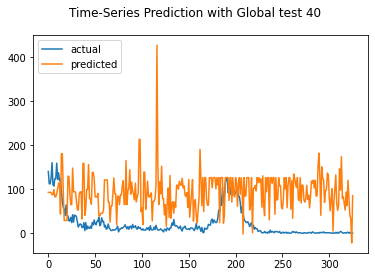

Test MAE: 73.652
Test RMSE: 84.711
Test sMAPE: 143.474
Test R Squared: -5.605
{'mae': 73.65218839469863, 'rmse': 84.71051473670096, 'smape': 143.47384560807146, 'r2': -5.604821083775847}


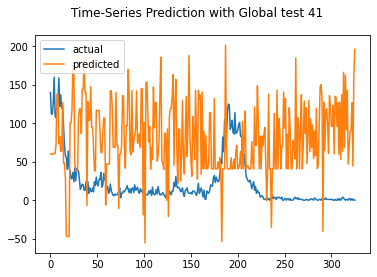

Test MAE: 110.221
Test RMSE: 126.828
Test sMAPE: 161.453
Test R Squared: -13.805
{'mae': 110.22127037691924, 'rmse': 126.82795092094953, 'smape': 161.45341294123975, 'r2': -13.805271229717842}


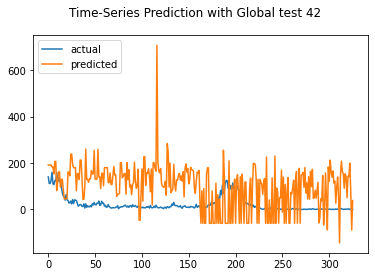

Test MAE: 93.435
Test RMSE: 114.718
Test sMAPE: 145.115
Test R Squared: -11.113
{'mae': 93.43545037124055, 'rmse': 114.71814373840405, 'smape': 145.11485907590682, 'r2': -11.112969907074728}


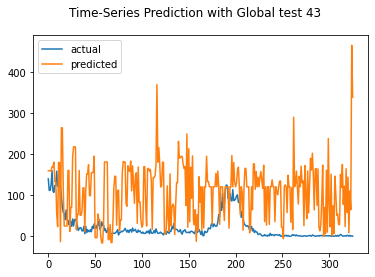

Test MAE: 66.809
Test RMSE: 81.615
Test sMAPE: 152.248
Test R Squared: -5.131
{'mae': 66.80880400602437, 'rmse': 81.61484081565361, 'smape': 152.24826181571945, 'r2': -5.130906487100587}


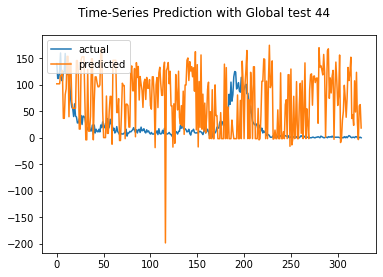

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 90.879
Test RMSE: 117.667
Test sMAPE: 170.328
Test R Squared: -11.744
{'mae': 90.87889613659104, 'rmse': 117.66730696767308, 'smape': 170.32810175657812, 'r2': -11.743773503428022}


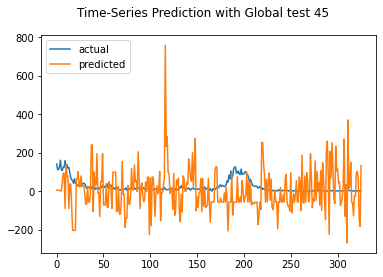

Test MAE: 88.831
Test RMSE: 111.180
Test sMAPE: 150.722
Test R Squared: -10.377
{'mae': 88.83121102243845, 'rmse': 111.17988985517843, 'smape': 150.72249946368296, 'r2': -10.377291755061094}


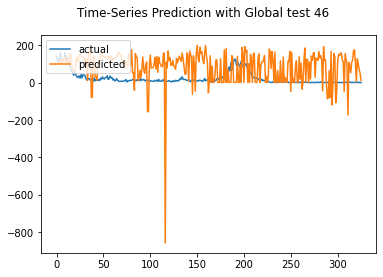

Test MAE: 59.857
Test RMSE: 79.854
Test sMAPE: 136.757
Test R Squared: -4.869
{'mae': 59.85679885726765, 'rmse': 79.85356155825014, 'smape': 136.75665149676098, 'r2': -4.869147148353346}


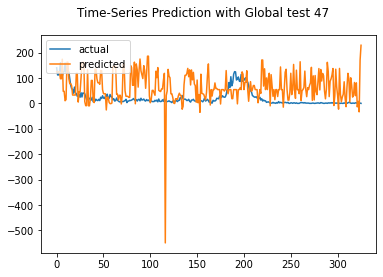

Test MAE: 45.192
Test RMSE: 54.712
Test sMAPE: 124.850
Test R Squared: -1.755
{'mae': 45.1921333438414, 'rmse': 54.71177310958702, 'smape': 124.85005182944842, 'r2': -1.7551674287069718}


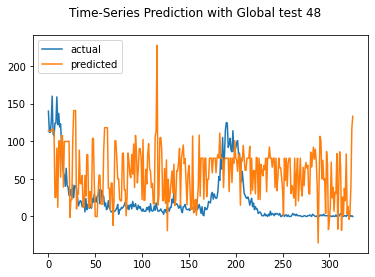

Test MAE: 59.257
Test RMSE: 77.784
Test sMAPE: 139.416
Test R Squared: -4.569
{'mae': 59.25712795537308, 'rmse': 77.7838701950425, 'smape': 139.41569778220472, 'r2': -4.568849898954663}


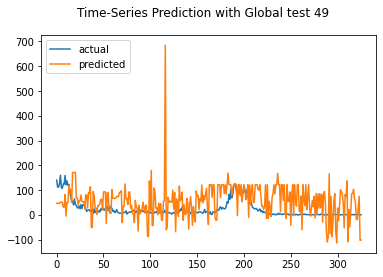

Test MAE: 99.594
Test RMSE: 130.171
Test sMAPE: 172.403
Test R Squared: -14.596
{'mae': 99.59401563614423, 'rmse': 130.17072606698616, 'smape': 172.40331212722276, 'r2': -14.595994406083017}


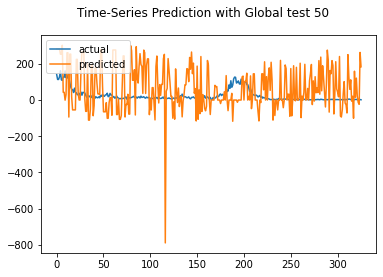

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 48.846
Test RMSE: 57.346
Test sMAPE: 128.068
Test R Squared: -2.027
{'mae': 48.84641100786215, 'rmse': 57.34595987994137, 'smape': 128.06829846863607, 'r2': -2.026858153654165}


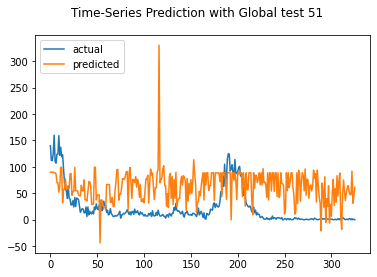

Test MAE: 86.076
Test RMSE: 118.335
Test sMAPE: 142.818
Test R Squared: -11.889
{'mae': 86.0762115097119, 'rmse': 118.33515358194013, 'smape': 142.81771815554032, 'r2': -11.888844193111685}


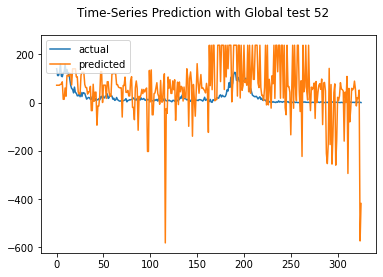

Test MAE: 67.321
Test RMSE: 78.374
Test sMAPE: 150.786
Test R Squared: -4.654
{'mae': 67.32053443954035, 'rmse': 78.37374379736934, 'smape': 150.78609260127453, 'r2': -4.653632852556786}


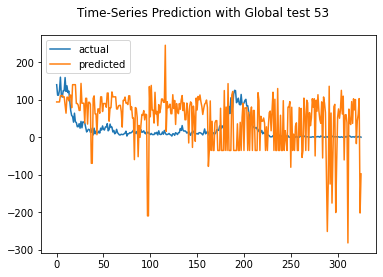

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 77.562
Test RMSE: 96.346
Test sMAPE: 144.977
Test R Squared: -7.544
{'mae': 77.56218156090543, 'rmse': 96.34552734148772, 'smape': 144.97679365048344, 'r2': -7.543769685003882}


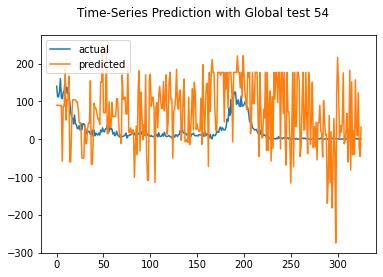

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 47.652
Test RMSE: 58.549
Test sMAPE: 127.327
Test R Squared: -2.155
{'mae': 47.65234928354164, 'rmse': 58.54880020214908, 'smape': 127.32727420367553, 'r2': -2.155167471271514}


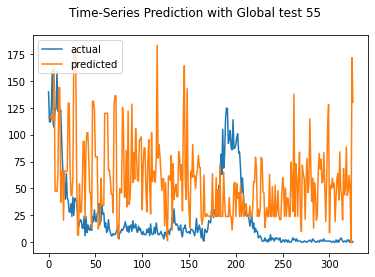

Test MAE: 79.320
Test RMSE: 118.867
Test sMAPE: 139.490
Test R Squared: -12.005
{'mae': 79.32041900874647, 'rmse': 118.866682832051, 'smape': 139.48999382094078, 'r2': -12.004890582349766}


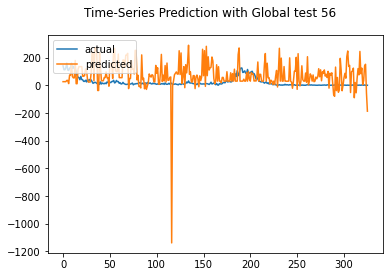

Test MAE: 72.315
Test RMSE: 86.569
Test sMAPE: 141.101
Test R Squared: -5.898
{'mae': 72.31533267417568, 'rmse': 86.56914119043432, 'smape': 141.100567871337, 'r2': -5.897832345285272}


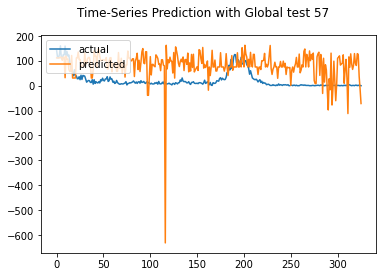

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 54.134
Test RMSE: 62.320
Test sMAPE: 132.577
Test R Squared: -2.575
{'mae': 54.13393045203086, 'rmse': 62.320097119195, 'smape': 132.57684383595011, 'r2': -2.574725177477845}


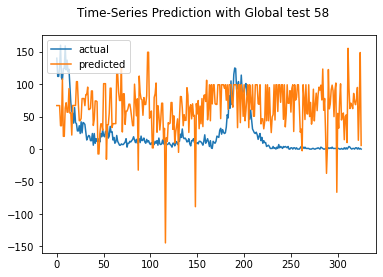

Test MAE: 54.848
Test RMSE: 70.723
Test sMAPE: 129.418
Test R Squared: -3.604
{'mae': 54.848466725437184, 'rmse': 70.72270443850032, 'smape': 129.4177760501372, 'r2': -3.6036694776807305}


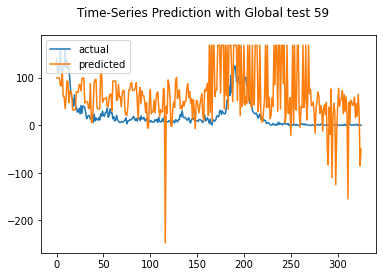

Test MAE: 64.272
Test RMSE: 84.415
Test sMAPE: 156.990
Test R Squared: -5.559
{'mae': 64.2718477804968, 'rmse': 84.41456581971684, 'smape': 156.98988398426823, 'r2': -5.558751828934771}


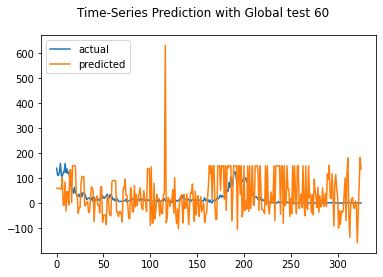

Test MAE: 72.487
Test RMSE: 85.951
Test sMAPE: 158.741
Test R Squared: -5.800
{'mae': 72.48700683614227, 'rmse': 85.95064745910875, 'smape': 158.74109278909623, 'r2': -5.799621231590181}


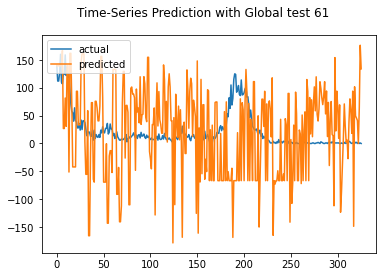

Test MAE: 52.323
Test RMSE: 72.654
Test sMAPE: 140.044
Test R Squared: -3.859
{'mae': 52.32313360648652, 'rmse': 72.6539398356715, 'smape': 140.04418332414576, 'r2': -3.858528516369323}


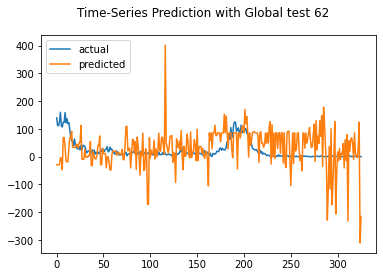

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 46.335
Test RMSE: 61.716
Test sMAPE: 132.187
Test R Squared: -2.506
{'mae': 46.33487567360416, 'rmse': 61.716005686079555, 'smape': 132.18663121036448, 'r2': -2.5057588332672385}


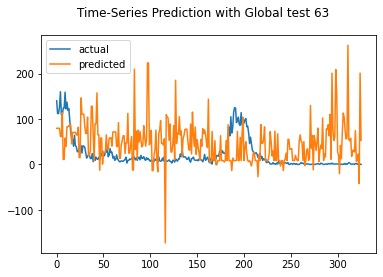

Test MAE: 66.974
Test RMSE: 100.028
Test sMAPE: 147.192
Test R Squared: -8.209
{'mae': 66.97378096624387, 'rmse': 100.02793345343885, 'smape': 147.19230555302693, 'r2': -8.209350649826884}


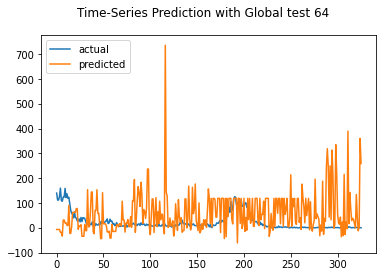

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 50.291
Test RMSE: 62.132
Test sMAPE: 143.329
Test R Squared: -2.553
{'mae': 50.291036586819985, 'rmse': 62.13153411835166, 'smape': 143.329422398497, 'r2': -2.5531256877829342}


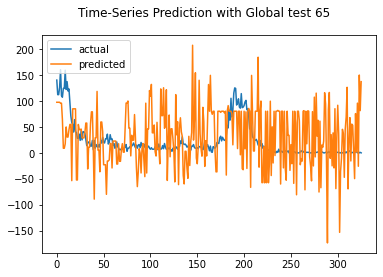

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 52.861
Test RMSE: 70.394
Test sMAPE: 132.171
Test R Squared: -3.561
{'mae': 52.860624176044404, 'rmse': 70.39417822023758, 'smape': 132.17124799491654, 'r2': -3.560998221821875}


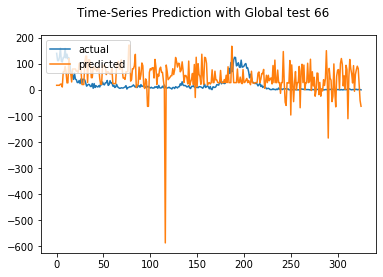

Test MAE: 49.516
Test RMSE: 59.065
Test sMAPE: 141.648
Test R Squared: -2.211
{'mae': 49.51640448147899, 'rmse': 59.06513870387046, 'smape': 141.6475132620783, 'r2': -2.211063341404928}


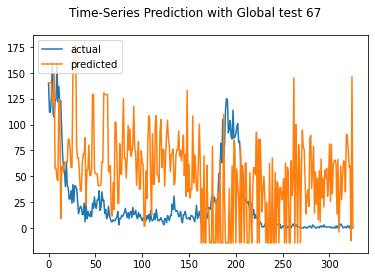

Test MAE: 88.563
Test RMSE: 104.694
Test sMAPE: 154.927
Test R Squared: -9.089
{'mae': 88.56262439306528, 'rmse': 104.69432565826186, 'smape': 154.92664619013289, 'r2': -9.088641835176784}


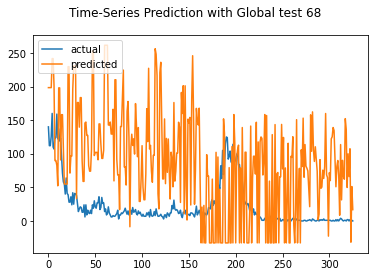

Test MAE: 101.251
Test RMSE: 140.626
Test sMAPE: 154.977
Test R Squared: -17.202
{'mae': 101.25131498633718, 'rmse': 140.62644598844656, 'smape': 154.97699243389428, 'r2': -17.20205483671332}


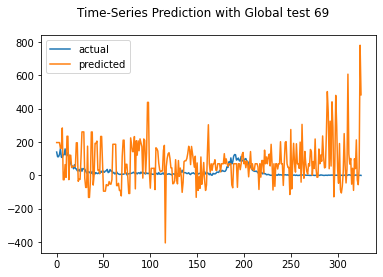

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 44.927
Test RMSE: 59.108
Test sMAPE: 126.542
Test R Squared: -2.216
{'mae': 44.92692305348768, 'rmse': 59.108442878170955, 'smape': 126.54216508612417, 'r2': -2.215773511346036}


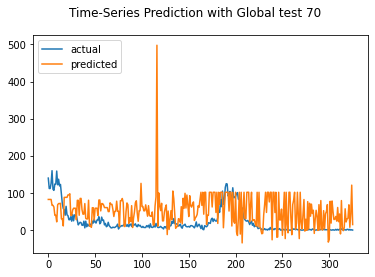

Test MAE: 82.301
Test RMSE: 99.628
Test sMAPE: 148.438
Test R Squared: -8.136
{'mae': 82.30075442571581, 'rmse': 99.62750716107661, 'smape': 148.4378392946006, 'r2': -8.135765504595414}


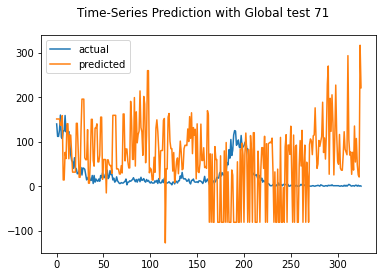

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 35.353
Test RMSE: 45.388
Test sMAPE: 132.537
Test R Squared: -0.896
{'mae': 35.352875396609306, 'rmse': 45.38822254190967, 'smape': 132.53656951172104, 'r2': -0.8961503360951615}


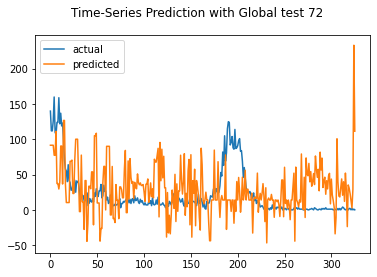

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 53.477
Test RMSE: 71.294
Test sMAPE: 150.188
Test R Squared: -3.678
{'mae': 53.47712982560228, 'rmse': 71.29368876820342, 'smape': 150.1883142905366, 'r2': -3.67830560284861}


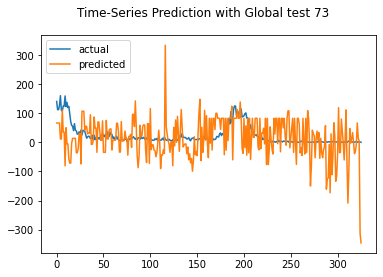

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 50.225
Test RMSE: 68.195
Test sMAPE: 151.258
Test R Squared: -3.280
{'mae': 50.225099460661774, 'rmse': 68.19523295841353, 'smape': 151.25847713813684, 'r2': -3.2804995013930753}


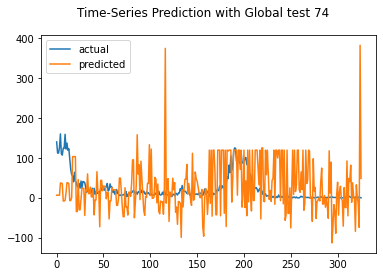

Test MAE: 50.300
Test RMSE: 56.882
Test sMAPE: 130.635
Test R Squared: -1.978
{'mae': 50.29993123803402, 'rmse': 56.88227556886574, 'smape': 130.63510245739036, 'r2': -1.9781072931463415}


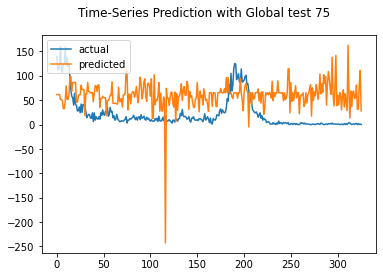

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 55.225
Test RMSE: 73.180
Test sMAPE: 133.668
Test R Squared: -3.929
{'mae': 55.22460077885835, 'rmse': 73.17969904886691, 'smape': 133.6677185608545, 'r2': -3.9291002880871764}


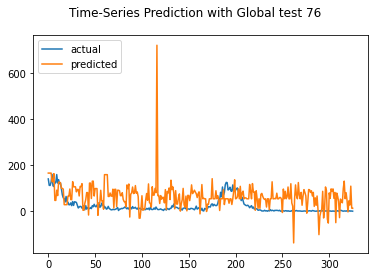

Test MAE: 36.143
Test RMSE: 46.151
Test sMAPE: 124.126
Test R Squared: -0.960
{'mae': 36.14342419282059, 'rmse': 46.15132493125494, 'smape': 124.1261175621991, 'r2': -0.9604454530635003}


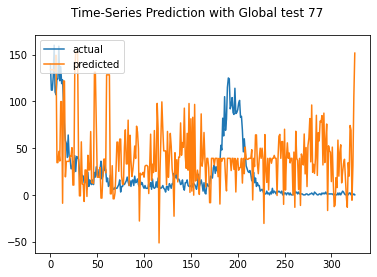

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 50.894
Test RMSE: 58.094
Test sMAPE: 130.741
Test R Squared: -2.106
{'mae': 50.89373523070037, 'rmse': 58.09385322669965, 'smape': 130.74078594539, 'r2': -2.1063242173365366}


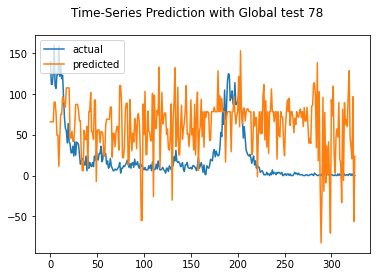

Test MAE: 93.544
Test RMSE: 121.385
Test sMAPE: 150.102
Test R Squared: -12.562
{'mae': 93.54429116232629, 'rmse': 121.38502496601173, 'smape': 150.10222204042154, 'r2': -12.561778289559289}


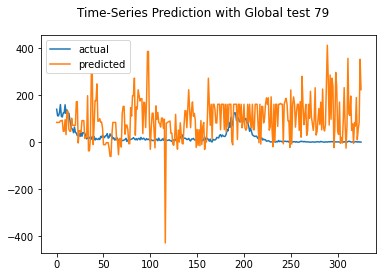

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 52.671
Test RMSE: 83.844
Test sMAPE: 138.097
Test R Squared: -5.470
{'mae': 52.671055018901825, 'rmse': 83.84430188221633, 'smape': 138.0966067846234, 'r2': -5.470435646761318}


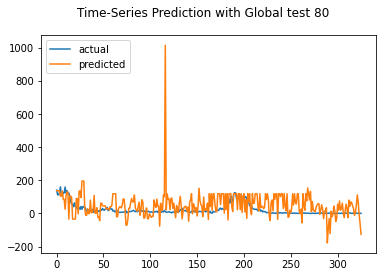

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 39.612
Test RMSE: 64.509
Test sMAPE: 122.639
Test R Squared: -2.830
{'mae': 39.61158560609525, 'rmse': 64.50936038044127, 'smape': 122.63907471719932, 'r2': -2.830292039259154}


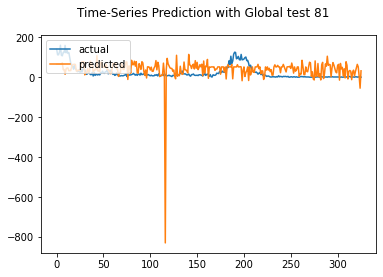

Test MAE: 66.571
Test RMSE: 76.299
Test sMAPE: 146.867
Test R Squared: -4.358
{'mae': 66.57125779017349, 'rmse': 76.29900182941952, 'smape': 146.8672993951712, 'r2': -4.3582642671807434}


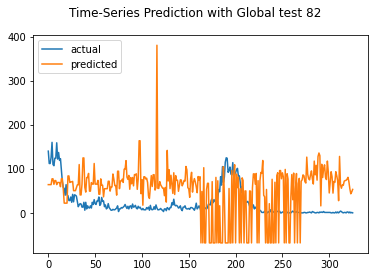

Test MAE: 73.641
Test RMSE: 99.086
Test sMAPE: 164.129
Test R Squared: -8.037
{'mae': 73.64129056210167, 'rmse': 99.08570602189984, 'smape': 164.129215028575, 'r2': -8.036670200215202}


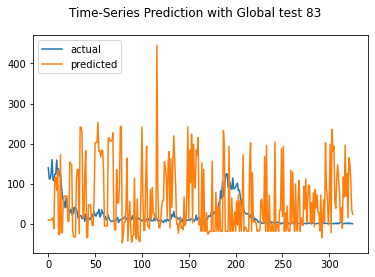

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 47.821
Test RMSE: 62.624
Test sMAPE: 130.487
Test R Squared: -2.610
{'mae': 47.821452698824594, 'rmse': 62.62447032714507, 'smape': 130.48715567892273, 'r2': -2.609728576249686}


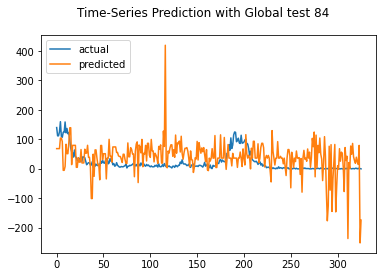

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 51.565
Test RMSE: 60.400
Test sMAPE: 130.555
Test R Squared: -2.358
{'mae': 51.56531560786663, 'rmse': 60.399950930728316, 'smape': 130.55465570219727, 'r2': -2.357836826186872}


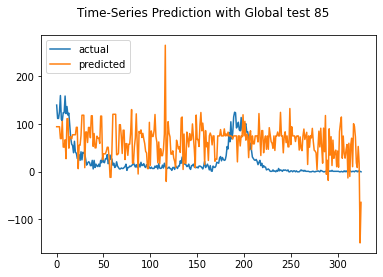

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 51.821
Test RMSE: 60.532
Test sMAPE: 132.382
Test R Squared: -2.373
{'mae': 51.82106731859453, 'rmse': 60.531796160100434, 'smape': 132.38234218060924, 'r2': -2.3725122672778776}


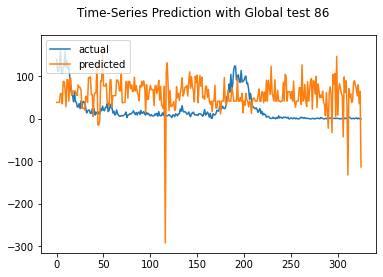

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 54.558
Test RMSE: 70.403
Test sMAPE: 134.926
Test R Squared: -3.562
{'mae': 54.55832261724706, 'rmse': 70.40312242583029, 'smape': 134.92567633327127, 'r2': -3.562157326125315}


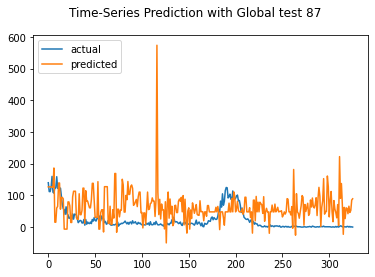

Test MAE: 76.287
Test RMSE: 93.304
Test sMAPE: 143.622
Test R Squared: -7.013
{'mae': 76.2870555128788, 'rmse': 93.30418414656219, 'smape': 143.62210547411104, 'r2': -7.012880311202675}


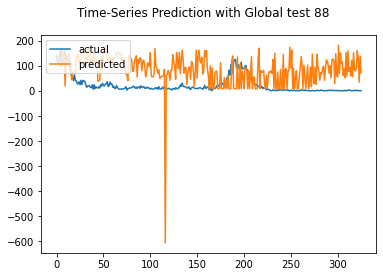

Test MAE: 48.879
Test RMSE: 59.476
Test sMAPE: 132.556
Test R Squared: -2.256
{'mae': 48.87880118310086, 'rmse': 59.47634066310749, 'smape': 132.5559268454524, 'r2': -2.2559287817160087}


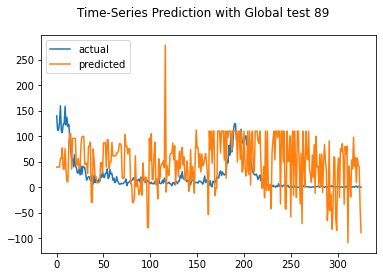

Test MAE: 64.423
Test RMSE: 73.165
Test sMAPE: 149.476
Test R Squared: -3.927
{'mae': 64.42342233804106, 'rmse': 73.1654865301873, 'smape': 149.47551779907215, 'r2': -3.9271858738983765}


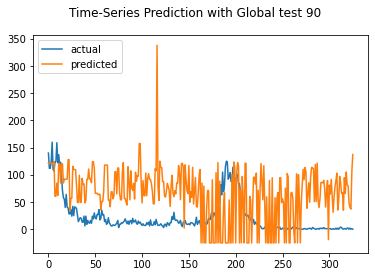

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 52.520
Test RMSE: 65.460
Test sMAPE: 133.087
Test R Squared: -2.944
{'mae': 52.520303550490574, 'rmse': 65.46036726246071, 'smape': 133.0871763922075, 'r2': -2.9440579858745655}


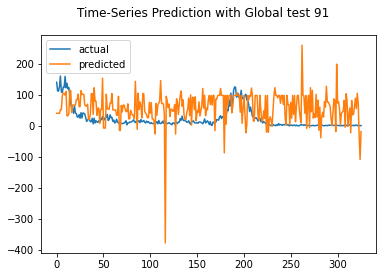

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 69.279
Test RMSE: 87.155
Test sMAPE: 142.508
Test R Squared: -5.992
{'mae': 69.27919764533365, 'rmse': 87.1549575116437, 'smape': 142.50791700553972, 'r2': -5.99150394791269}


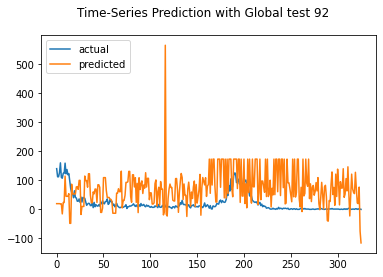

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 50.847
Test RMSE: 65.005
Test sMAPE: 147.541
Test R Squared: -2.889
{'mae': 50.846776149755605, 'rmse': 65.00483234845076, 'smape': 147.54053150490583, 'r2': -2.8893560409492802}


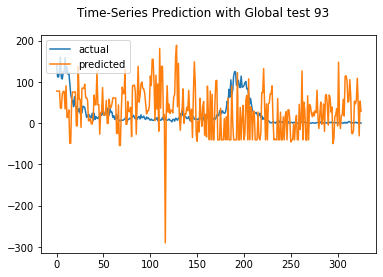

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 55.165
Test RMSE: 67.159
Test sMAPE: 136.383
Test R Squared: -3.151
{'mae': 55.16499078529744, 'rmse': 67.15906240800675, 'smape': 136.38317443946534, 'r2': -3.151410362633385}


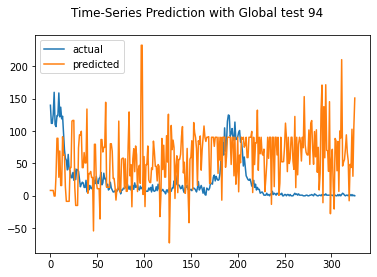

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 46.369
Test RMSE: 61.241
Test sMAPE: 138.361
Test R Squared: -2.452
{'mae': 46.36946969749006, 'rmse': 61.240915809872774, 'smape': 138.3614745569017, 'r2': -2.451991911484025}


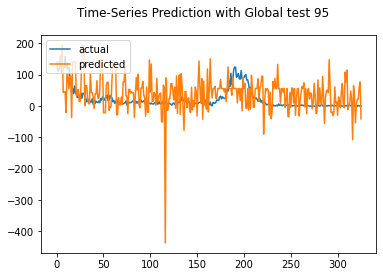

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 71.507
Test RMSE: 86.631
Test sMAPE: 140.381
Test R Squared: -5.908
{'mae': 71.50714212363484, 'rmse': 86.6313430917594, 'smape': 140.3805332701156, 'r2': -5.9077484060218355}


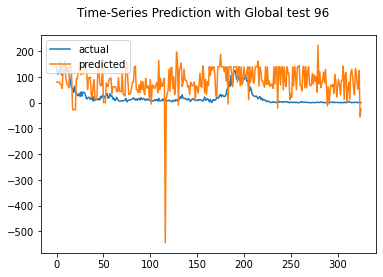

Test MAE: 70.233
Test RMSE: 108.271
Test sMAPE: 155.965
Test R Squared: -9.790
{'mae': 70.23317109340904, 'rmse': 108.27144363142995, 'smape': 155.96523492809217, 'r2': -9.789821775382876}


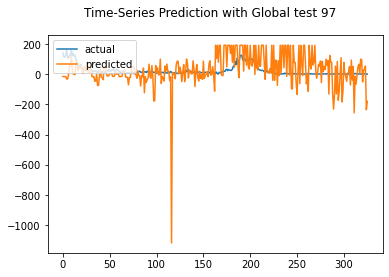

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 66.404
Test RMSE: 99.602
Test sMAPE: 153.140
Test R Squared: -8.131
{'mae': 66.40356435311352, 'rmse': 99.60161542586943, 'smape': 153.14005727126562, 'r2': -8.131017617363351}


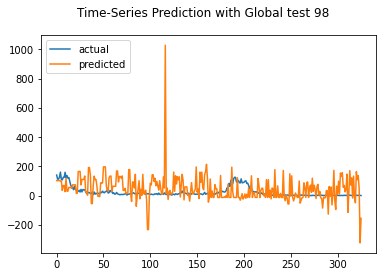

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 44.519
Test RMSE: 88.966
Test sMAPE: 129.642
Test R Squared: -6.285
{'mae': 44.519213194861734, 'rmse': 88.96557083834826, 'smape': 129.64199661337483, 'r2': -6.285013411326392}


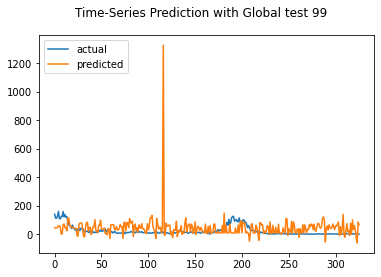

rmse : average=81.119, std=22.098
mae : average=63.032, std=17.437
smape : average=142.563, std=10.964
r2 : average=-5.506, std=3.899


([81.11942251732349, 22.098103778635295],
 [63.03160830567859, 17.43731043329525],
 [142.56348516406638, 10.963803022559759],
 [-5.506166328191268, 3.899371422003436])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
